# Train Neural Net
> NN training notebook

### To-do
---
- Early stopping
- Repeats
- Rename `epochs` ---> `max_epochs`
- "Best model" saving after training and selecting best model using some kind of criteria:
```python
import pickle
file_name = '/tmp/mymodel.pkl'
# Save
with open(file_name, 'wb') as f:
    pickle.dump(net, f)
# Load it back when needed
with open(file_name, 'rb') as f:
    new_net = pickle.load(f)
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, numpy as np, matplotlib.pyplot as plt

import matplotlib
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
# matplotlib.rcParams['font.size']= 22 # use for presentation

In case if you want to use CUDA-enabled GPU

- the for using GPU is not yet complete, but could still work.
- Need to implement mini-batch
- Right now tensors are copied to GPU from the beginning, which won't work for large datasets as we will fill up the GPU memory. But this way is faster as we don't spend time copying the tensors between devices.

In [11]:
# !nvidia-smi

device(type='cuda', index=3)

**choose your GPU device here**

In [12]:
if torch.cuda.is_available():
#     device = torch.device('cuda')
    device = torch.device('cuda:3')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cuda:3


## Training

`nn` module implements these networks (not the same as torch.nn):
- `fcNet` : fully-connected neural network, linear layer as a final layer (a.k.a. linear combiner)
    - e.g. Initialise network with two (hidden) layers, with dimensions `[8, 4]`
    ```python
model = fcNet(input_dim, layer_dims=[8,4], output_dim=1)
Y = model(x)
```
- `diffNet` : difference network. `diffNet(x,Y0) = Y0 + fcNet(x)`
    - e.g. Init. diff. net with 3 hidden layers, with dim-s `[16,8,4]`
    ```python
model = diffNet(input_dim, layer_dims=[16,8,4], output_dim=1)
Y = model(x, Y0)
```

In [13]:
from torch.nn import MSELoss

In [21]:
# Neural network implementations: fcNet, diffNet
from src.nnets import fcNet, diffNet, get_model, train_model

### Persistence

In [23]:
with open('persistence_T5.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
print('Persistence:',persistence)

Persistence: {'lead_time': 5, 'Persistence_Euclidean': 0.7021652369157633, 'Persistence_MSE': 1.4043304738315265}


### Naive Window

In [54]:
# Training data
with open('train_preprocessed_naivewin51.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_naivewin51.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([574, 52]) torch.float32,
test: torch.Size([247, 52]) torch.float32


In [55]:
x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}')

Training x torch.Size([574, 50]), Y0 torch.Size([574, 1]), y torch.Size([574, 1])


In [56]:
x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}')

x_test torch.Size([247, 50]), Y0_test torch.Size([247, 1]), y_test torch.Size([247, 1])


In [57]:
# Network size:
input_dim = x.shape[1]
layer_dims = [128,64,32]
dropout_p = [.25] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.394469141960144, test_loss: 1.464566946029663
epoch 100> train_loss: 0.3880191147327423, test_loss: 1.7670576572418213
epoch 200> train_loss: 0.14125646650791168, test_loss: 1.8671046495437622
epoch 300> train_loss: 0.0881069228053093, test_loss: 1.8112810850143433
epoch 400> train_loss: 0.07021601498126984, test_loss: 1.7881865501403809
epoch 500> train_loss: 0.06214381009340286, test_loss: 1.7636319398880005
epoch 600> train_loss: 0.057764384895563126, test_loss: 1.7555574178695679
epoch 700> train_loss: 0.05438917502760887, test_loss: 1.7557506561279297
epoch 800> train_loss: 0.0540909580886364, test_loss: 1.749915361404419
epoch 900> train_loss: 0.05381176248192787, test_loss: 1.7475841045379639


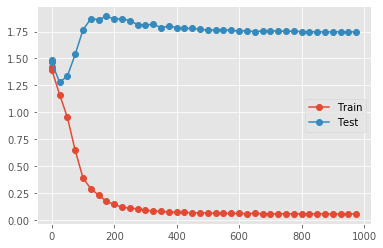

In [58]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

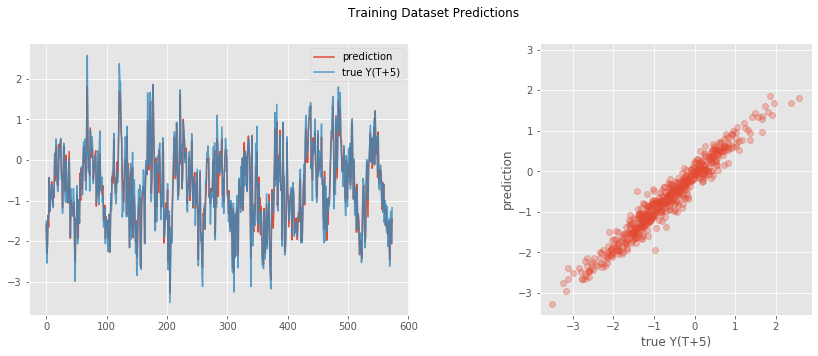

In [59]:
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

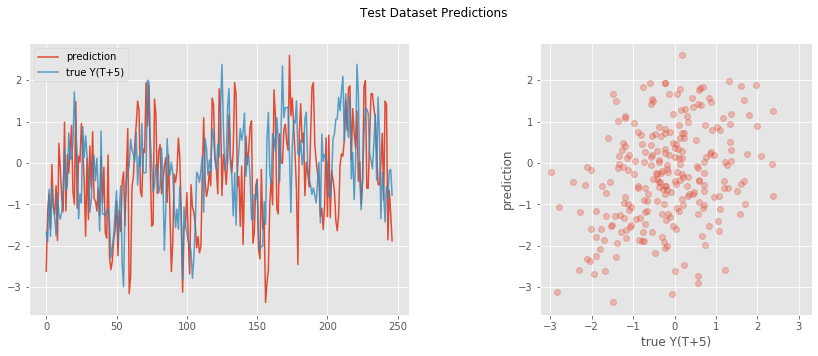

In [60]:
net.eval()
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

In [61]:
# another way to calculate/re-calculate MSE loss for the model
from src.utils import mse
mse_loss_with_np = mse(net(x_test,Y0_test).detach().cpu().numpy(), y_test.cpu().numpy()) # same as MSELoss()'s result
print('MSE loss:',mse_loss_with_np)

MSE loss: 1.7455968


- **Lagged (Cross-) Correlation**

Train lag peak:0
Test lag peak:5


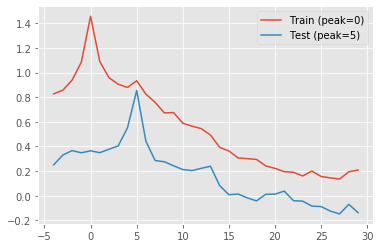

In [62]:
from src.utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().cpu().numpy().ravel(), 
                                        y.cpu().numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().cpu().numpy().ravel(),
                                      y_test.cpu().numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Difference Net

In [63]:
# Training data
with open('train_preprocessed_diff51.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_diff51.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([574, 52]) torch.float32,
test: torch.Size([247, 52]) torch.float32


In [64]:
x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)

print(f'Training x {x.shape}')

Training x torch.Size([574, 50])


In [65]:
x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'Training x_test {x_test.shape}')

Training x_test torch.Size([247, 50])


In [66]:
# Network size:
input_dim = x.shape[1]
layer_dims = [128,64,32]
dropout_p = [.25] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.361693024635315, test_loss: 1.4193943738937378
epoch 100> train_loss: 0.17446628212928772, test_loss: 1.0257070064544678
epoch 200> train_loss: 0.07822553813457489, test_loss: 0.9780672788619995
epoch 300> train_loss: 0.056511830538511276, test_loss: 0.975613534450531
epoch 400> train_loss: 0.05236083269119263, test_loss: 0.9805716872215271
epoch 500> train_loss: 0.04877172037959099, test_loss: 0.9767172336578369
epoch 600> train_loss: 0.04407428950071335, test_loss: 0.9761527180671692
epoch 700> train_loss: 0.042533956468105316, test_loss: 0.9751777648925781
epoch 800> train_loss: 0.042503904551267624, test_loss: 0.974250078201294
epoch 900> train_loss: 0.040806449949741364, test_loss: 0.9727158546447754


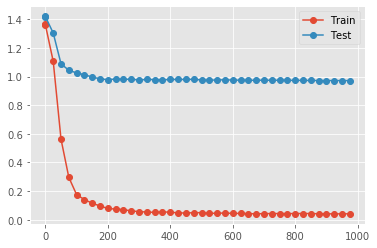

In [67]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

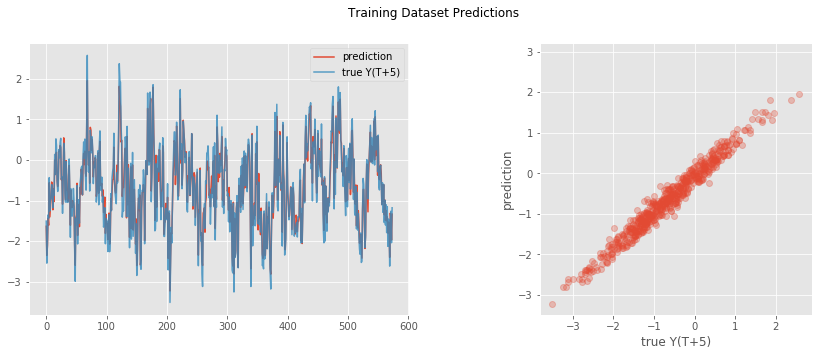

In [68]:
net.eval()
pred = net(x,Y0).detach().cpu().numpy()
target = y.cpu().numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

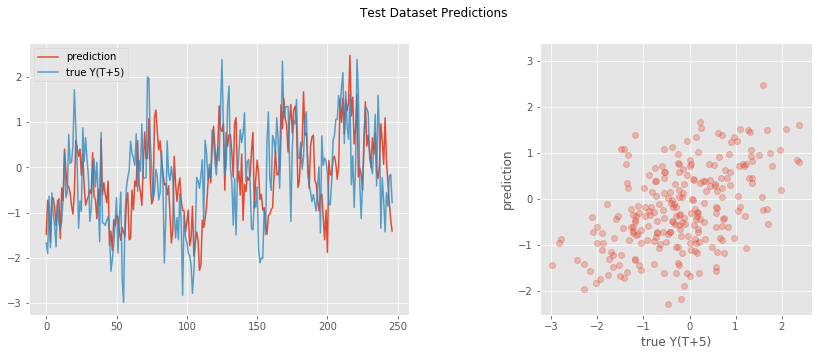

In [69]:
net.eval()
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

Train lag peak:0
Test lag peak:5


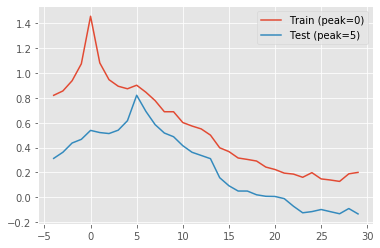

In [70]:
from src.utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().cpu().numpy().ravel(), 
                                        y.cpu().numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().cpu().numpy().ravel(),
                                      y_test.cpu().numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Difference with step size=Lead_time

In [120]:
# Training data
with open('train_preprocessed_stepdiff51.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_stepdiff51.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)

print(f'Training x {x.shape}')


x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'x_test {x_test.shape}')

Shapes
train: torch.Size([574, 48]) torch.float32,
test: torch.Size([247, 48]) torch.float32
Training x torch.Size([574, 46])
x_test torch.Size([247, 46])


In [126]:
# Network size:
input_dim = x.shape[1]
layer_dims = [128,64,64,64]
dropout_p = [.25] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.3647732734680176, test_loss: 1.4342290163040161
epoch 100> train_loss: 0.21828588843345642, test_loss: 1.0863865613937378
epoch 200> train_loss: 0.08807011693716049, test_loss: 1.062011480331421
epoch 300> train_loss: 0.06576290726661682, test_loss: 1.0406540632247925
epoch 400> train_loss: 0.05077158287167549, test_loss: 1.0375133752822876
epoch 500> train_loss: 0.04849392920732498, test_loss: 1.0324198007583618
epoch 600> train_loss: 0.04602380469441414, test_loss: 1.0342999696731567
epoch 700> train_loss: 0.04545048251748085, test_loss: 1.03348708152771
epoch 800> train_loss: 0.04371201619505882, test_loss: 1.0326915979385376
epoch 900> train_loss: 0.04342270642518997, test_loss: 1.0333507061004639


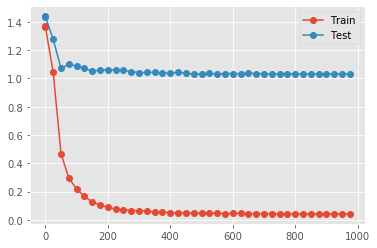

In [127]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

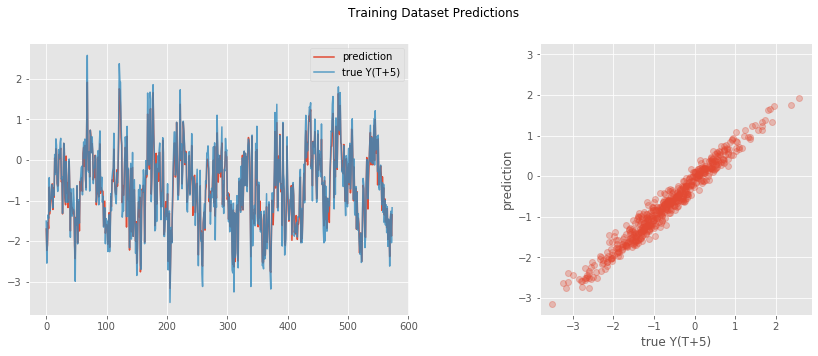

In [128]:
net.eval()
pred = net(x,Y0).detach().cpu().numpy()
target = y.cpu().numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

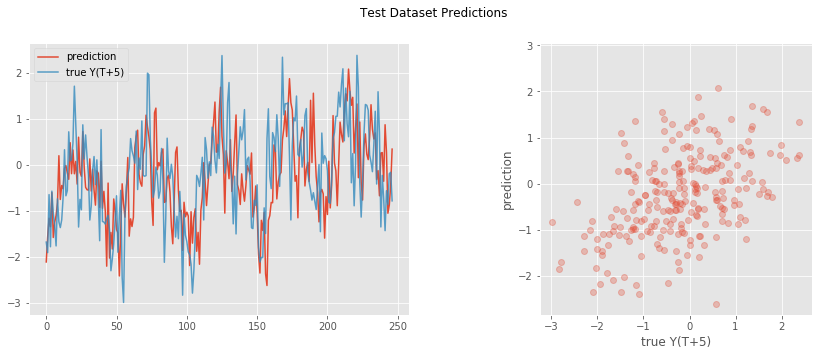

In [129]:
net.eval()
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

Train lag peak:0
Test lag peak:5


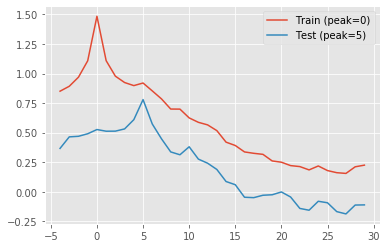

In [130]:
from src.utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().cpu().numpy().ravel(), 
                                        y.cpu().numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().cpu().numpy().ravel(),
                                      y_test.cpu().numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Momentum and Force

In [225]:
# Training data
with open('train_preprocessed_mntfrcwin51.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_mntfrcwin51.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)

print(f'Training x {x.shape}')


x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'x_test {x_test.shape}')

Shapes
train: torch.Size([574, 125]) torch.float32,
test: torch.Size([247, 125]) torch.float32
Training x torch.Size([574, 123])
x_test torch.Size([247, 123])


In [228]:
# Network size:
input_dim = x.shape[1]
layer_dims = [128,64,64,64]
dropout_p = [.3] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 10000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.3617316484451294, test_loss: 1.4322643280029297
epoch 1000> train_loss: 0.08083803206682205, test_loss: 1.0823395252227783
epoch 2000> train_loss: 0.08065631240606308, test_loss: 1.0821999311447144
epoch 3000> train_loss: 0.08064273744821548, test_loss: 1.082207202911377
epoch 4000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 5000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 6000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 7000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 8000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377
epoch 9000> train_loss: 0.08064272999763489, test_loss: 1.082207202911377


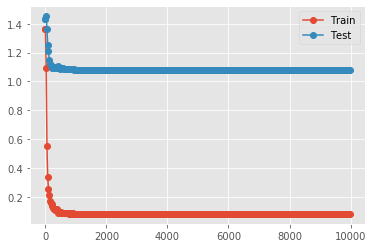

In [229]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler = None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

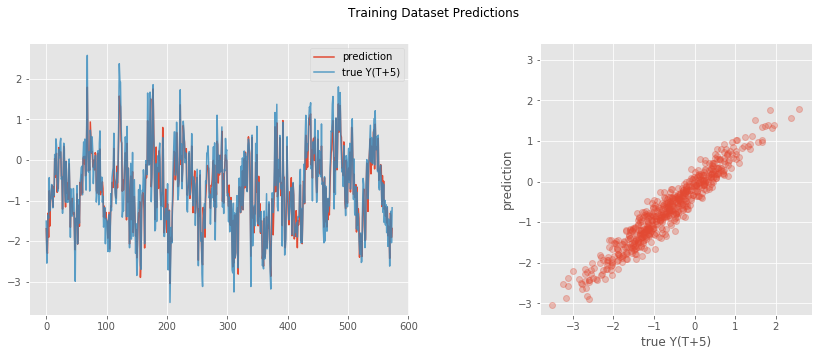

In [230]:
net.eval()
pred = net(x,Y0).detach().cpu().numpy()
target = y.cpu().numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

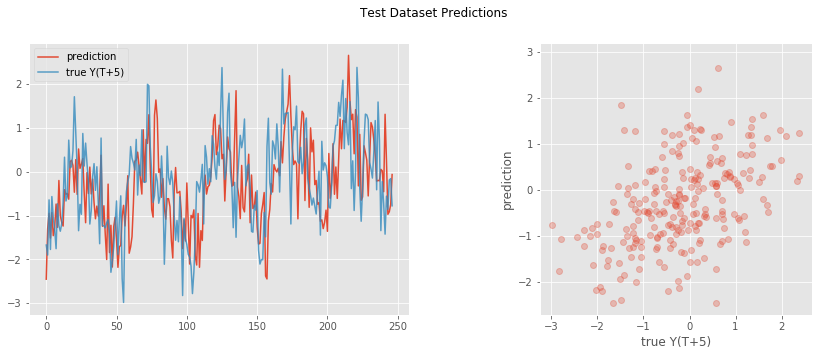

In [231]:
net.eval()
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

Train lag peak:0
Test lag peak:5


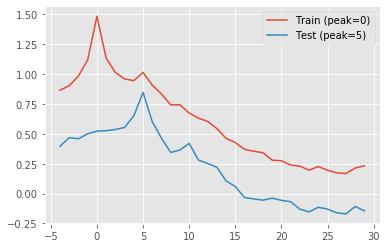

In [232]:
from src.utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().cpu().numpy().ravel(), 
                                        y.cpu().numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().cpu().numpy().ravel(),
                                      y_test.cpu().numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')